# Bibliotek

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skyfield.api import EarthSatellite, load
from sgp4.api import Satrec, jday
from datetime import datetime, timedelta
from PIL import Image
import plotly.graph_objects as go
import plotly.express as px
import math

# Funksjoner og Konstanter

In [42]:
def calc_sun_sync_params(altitudes_km):
    """
    Calculate sun-synchronous orbital parameters for satellites at given altitudes.

    Parameters:
    altitudes_km (list of float): List of altitudes in kilometers.

    Returns:
    pd.DataFrame: A DataFrame containing the orbital parameters for each altitude.
    """
    # Constants for Earth and orbit calculations
    R_EARTH = 6378.137e3  # Earth's equatorial radius in meters
    mu = 3.986004418e14  # Earth's gravitational parameter in m^3 s^-2
    J2 = 1.08263e-3  # Earth's J2 zonal harmonic for oblateness effect
    omega_earth = 2 * np.pi / (365.25 * 24 * 3600)  # Earth's angular velocity (rad/s)
    Psr = 4.56e-6  # Solar radiation pressure at 1 AU, N/m^2
    AU = 149597870.7e3  # Astronomical unit in meters

    # Satellite mass and drag properties
    U=12 # Satellite size
    sat_mass = 40  # kg
    Cd = 2.2  # drag coefficient
    A = 0.1*0.1*U # cross-sectional area, m^2 (increased for visible solar pressure effects)
    rho0 = 1.225  # sea-level air density, kg/m^3
    rho = lambda h: rho0 * np.exp(-h / 8.5)  # atmospheric density model, kg/m^3

    data = {
        "Altitude (km)": [],
        "Period (minutes)": [],
        "Revs per day": [],
        "Inclination (degrees)": [],
        "Semi-major Axis (meters)": [],
        "Eccentricity": [],
        "RAAN (degrees)": [],
        "Argument of Perigee (degrees)": [],
        "BSTAR": []
    }
    
    for altitude_km in altitudes_km:
        if not isinstance(altitude_km, (int, float)):
            raise ValueError("All altitudes must be numeric values.")
        
        r = R_EARTH + altitude_km * 1e3  # Semi-major axis in meters
        T = 2 * np.pi * np.sqrt(r**3 / mu)  # Orbital period in seconds
        T_minutes = T / 60  # Convert period to minutes
        T_hours = T / 3600  # Convert period to hours
        revs_per_day = 24 / T_hours  # Calculate revolutions per day

        # Calculate inclination for a sun-synchronous orbit
        inclination = np.degrees(np.arccos(-2 * r**(7/2) * omega_earth / (3 * J2 * R_EARTH**2 * np.sqrt(mu))))

        # Set eccentricity to zero for a near-circular orbit
        eccentricity = 0.0

        # RAAN and Argument of Perigee are typically set to specific values for sun-synchronous orbits
        RAAN = 0.0  # Placeholder value
        argument_of_perigee = 0.0  # Placeholder value

        # Calculate the BSTAR drag term for the satellite
        bstar =  (rho0 * Cd * A) / (sat_mass*2) 


        data["Altitude (km)"].append(altitude_km)
        data["Period (minutes)"].append(T_minutes)
        data["Revs per day"].append(revs_per_day)
        data["Inclination (degrees)"].append(inclination)
        data["Semi-major Axis (meters)"].append(r)
        data["Eccentricity"].append(eccentricity)
        data["RAAN (degrees)"].append(RAAN)
        data["Argument of Perigee (degrees)"].append(argument_of_perigee)
        data["BSTAR"].append(bstar)
    
    df_orbital_params = pd.DataFrame(data)
    return df_orbital_params


def generate_tle(df):
    """
    Generate Two Line Elements (TLE) from orbital parameters in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the orbital parameters.

    Returns:
    list of tuples: List of TLE lines and their descriptions.
    """
    tle_lines = []
    for index, row in df.iterrows():
        satellite_number = 99990 + index + 1  # Example satellite number
        epoch = "24304.50000000"  # Example epoch (YYDDD.DDDDDDDD)
        inclination = f"{row['Inclination (degrees)']:.4f}".rjust(8)
        raan = f"{row['RAAN (degrees)']:.4f}".rjust(8)
        eccentricity = f"{int(row['Eccentricity'] * 1e7):07d}"
        argument_of_perigee = f"{row['Argument of Perigee (degrees)']:.4f}".rjust(8)
        mean_anomaly = "000.0000"  # Placeholder value
        mean_motion = f"{row['Revs per day']:.8f}".rjust(11)
        revolution_number = f"{index + 1:05d}"
        #bstar = "00000-0" # Placeholder value

        bstar_value = f"{row['BSTAR']:.5e}"
        bstar_coef, bstar_exp = bstar_value.split('e')
        bstar = f"{int(float(bstar_coef) * 1e4):04d}{int(bstar_exp):+d}".replace("+", "")

        line1 = f"1 {satellite_number}U 21001A   {epoch}  .00000000  00000-0  {bstar} 0  9991"
        line2 = f"2 {satellite_number} {inclination} {raan} {eccentricity} {argument_of_perigee} {mean_anomaly} {mean_motion} {revolution_number}"

        label = f"Satellite {index + 1} ({row['Altitude (km)']} km)"
        tle_lines.append(((line1, line2), label))

    return tle_lines



def sphere(size, texture): 
    N_lat = int(texture.shape[0])
    N_lon = int(texture.shape[1])
    theta = np.linspace(0,2*np.pi,N_lat)
    phi = np.linspace(0,np.pi,N_lon)
    
    # Set up coordinates for points on the sphere
    x0 = size * np.outer(np.cos(theta),np.sin(phi))
    y0 = size * np.outer(np.sin(theta),np.sin(phi))
    z0 = size * np.outer(np.ones(N_lat),np.cos(phi))
    
    return x0, y0, z0

def create_satellite(tle_line1, tle_line2):
    return EarthSatellite(tle_line1, tle_line2)

def propagate_orbit(satellite, start_time, end_time, time_step):
    ts = load.timescale()
    times = ts.utc(start_time.year, start_time.month, start_time.day, 
                   start_time.hour, start_time.minute, start_time.second + np.arange(0, int((end_time - start_time).total_seconds()), time_step))
    geocentric = satellite.at(times)
    positions = geocentric.position.km
    velocities = geocentric.velocity.km_per_s
    return positions, velocities

def plot_orbits(tle_lines, time_step=60, time_delta=120):
    """
    Plots the orbits of satellites with Earth rotation effect in 3D.

    Parameters:
    tle_lines (list of tuples): List of tuples with TLE lines and satellite labels.
    time_step (int): Time step in seconds for orbit propagation.
    time_delta (int): Duration in minutes for orbit propagation.

    Returns:
    None: Displays an interactive 3D plot with Earth rotation.
    """
    earth_radius = 6371.137  # Earth's radius in kilometers

    # Define the time range
    start_time = datetime.now()
    end_time = start_time + timedelta(minutes=math.ceil(time_delta))
    num_steps = int((end_time - start_time).total_seconds() / time_step)

    # Calculate Earth rotation angles for each time step
    deg = 360 / (24*60)
    rotation_angles = np.linspace(0, time_delta * deg, num_steps) % 360 

    # Initialize lists for positions, velocities, and labels
    positions_list = []
    velocities_list = []
    labels = []

    # Propagate each satellite orbit
    for (tle_line1, tle_line2), label in tle_lines:
        satellite = create_satellite(tle_line1, tle_line2)
        positions, velocities = propagate_orbit(satellite, start_time, end_time, time_step)
        positions_list.append(positions)
        velocities_list.append(velocities)
        labels.append(label)

    # Start Plotly figure
    fig = go.Figure()

    # Add Earth with texture
    texture = np.asarray(Image.open('temp.jpg')).T  # Load the Earth texture map
    colorscale =[[0.0, 'rgb(30, 59, 117)'],
                 [0.1, 'rgb(46, 68, 21)'],
                 [0.2, 'rgb(74, 96, 28)'],
                 [0.3, 'rgb(115,141,90)'],
                 [0.4, 'rgb(122, 126, 75)'],
                 [0.6, 'rgb(122, 126, 75)'],
                 [0.7, 'rgb(141,115,96)'],
                 [0.8, 'rgb(223, 197, 170)'],
                 [0.9, 'rgb(237,214,183)'],
                 [1.0, 'rgb(255, 255, 255)']]
    xs, ys, zs = sphere(earth_radius, texture)
    fig.add_trace(go.Surface(
        x=xs, y=ys, z=zs,
        surfacecolor=texture,
        colorscale=colorscale,
        showscale=False,
        hoverinfo='none',
        name='Earth',
        showlegend=True
    ))

    # Plot each satellite's orbit and adjust for Earth's rotation
    cmap = plt.get_cmap('cool')
    for i, (positions, velocities, label) in enumerate(zip(positions_list, velocities_list, labels)):
        adjusted_positions = []

        # Apply Earth's rotation to each position
        for j, pos in enumerate(positions.T):
            rotation_angle_rad = np.radians(rotation_angles[j])
            rotation_matrix = np.array([
                [np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                [np.sin(rotation_angle_rad),  np.cos(rotation_angle_rad), 0],
                [0, 0, 1]
            ])
            rotated_pos = rotation_matrix @ pos
            adjusted_positions.append(rotated_pos)

        adjusted_positions = np.array(adjusted_positions).T

        # Set color and hover text for each satellite's orbit
        color = cmap(i / len(positions_list))
        hover_text = [f"Velocity: {np.linalg.norm(vel):.2f} km/s<br>Altitude: {np.linalg.norm(pos) - earth_radius:.2f} km"
                      for vel, pos in zip(velocities.T, adjusted_positions.T)]
        fig.add_trace(go.Scatter3d(
            x=adjusted_positions[0], y=adjusted_positions[1], z=adjusted_positions[2],
            mode='lines',
            name=label,
            line=dict(color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})'),
            text=hover_text,
            hoverinfo='text'
        ))

    # Update layout for enhanced visuals
    fig.update_layout(
        title=dict(
            text='Satellite Orbits',
            font=dict(size=24, color='white'),
            x=0.5, y=0.95, xanchor='center', yanchor='top'
        ),
        width=800,
        height=600,
        scene=dict(
            xaxis=dict(backgroundcolor='black', color='white', gridcolor='gray', title='x (km)'),
            yaxis=dict(backgroundcolor='black', color='white', gridcolor='gray', title='y (km)'),
            zaxis=dict(backgroundcolor='black', color='white', gridcolor='gray', title='z (km)'),
            bgcolor='black'
        ),
        legend=dict(
            x=0, y=1, xanchor='left', yanchor='top', font=dict(size=10, color="white")
        ),
        margin=dict(r=1, l=1, b=1, t=1),
        paper_bgcolor='black',
        plot_bgcolor='black'
    )

    # Show the plot
    fig.show()

def plot_map(tle_lines, time_step=60, time_delta=120):
    """
    Projects satellite orbits onto a 2D map of Earth.

    Parameters:
    tle_lines (list of tuples): List of tuples containing TLE lines and satellite labels.
    time_step (int): Time step in seconds for orbit propagation. Default is 60 seconds.
    time_delta (int): Duration in minutes for orbit propagation. Default is 120 min.

    Returns:
    None: Displays an interactive 2D map of orbit paths using Plotly.
    """
    
    # Setup time range
    start_time = datetime.now()
    end_time = start_time + timedelta(minutes=math.ceil(time_delta))
    num_steps = int((end_time - start_time).total_seconds() / time_step)

    # Pre-calculate Earth's rotation angles for each time step
    deg = 360 / (24*60) # Earth rotation in degrees per minute
    rotation_angles = np.linspace(0, time_delta * deg, num_steps) % 360  # Earth rotates 15° per hour

    # Initialize lists for latitude, longitude, and labels
    latitudes, longitudes, labels, timestamps = [], [], [], []

    # Process each satellite's TLE and orbit data
    for (tle_line1, tle_line2), label in tle_lines:
        satellite = create_satellite(tle_line1, tle_line2)
        positions, _ = propagate_orbit(satellite, start_time, end_time, time_step)

        # Calculate latitude and longitude for each position
        for i, pos in enumerate(positions.T):
            lat = np.degrees(np.arctan2(pos[2], np.sqrt(pos[0]**2 + pos[1]**2)))
            lon = (np.degrees(np.arctan2(pos[1], pos[0])) + rotation_angles[i]) % 360
            if lon > 180:
                lon -= 360

            # Append calculated data to lists
            latitudes.append(lat)
            longitudes.append(lon)
            labels.append(label)
            timestamps.append((start_time + timedelta(seconds=i * time_step)).strftime('%Y-%m-%d %H:%M:%S'))

    # Plot the projected orbit paths on a 2D map
    fig_map = px.scatter_geo(
        lat=latitudes,
        lon=longitudes,
        color=labels,
        title="Satellite Orbit Path Projections",
        hover_name=labels,
        hover_data={"Timestamp": timestamps}
    )

    # Style the map
    fig_map.update_geos(
        showland=True,
        landcolor="rgb(217, 217, 217)",
        projection_type="natural earth",
        bgcolor="black"
    )
    fig_map.update_layout(
        width=800,
        height=600,
        paper_bgcolor="black",
        plot_bgcolor="black",
        font=dict(color="white"),
        legend=dict(
            title=None, x=0, y=1, xanchor='left', yanchor='top', font=dict(size=10, color="white")
        ),
        title=dict(
            font=dict(size=24, color='white'),
            xanchor='center', yanchor='top', x=0.5, y=0.95
        ),
        margin=dict(r=1, l=1, b=1, t=1)
    )

    # Show the map
    fig_map.show()

def plot_orbit_heights(tle_lines):
    """
    Plots the height of the orbits over time for multiple satellites using their TLE data.

    Parameters:
    tle_lines (list of tuples): A list of tuples where each tuple contains two strings representing the TLE lines of a satellite and a label for the satellite.

    Returns:
    None: The function displays a plot of the altitudes over time for the satellites.
    """
    # Earth's radius in kilometers
    earth_radius = 6378.1

    # Maximum simulation duration
    max_duration = timedelta(days=365 * 15)

    # Initialize plot
    plt.figure(figsize=(10, 6))

    for (tle_line1, tle_line2), label in tle_lines:
        # Parse the TLE data
        satellite = Satrec.twoline2rv(tle_line1, tle_line2)
        
        # Initialize time variables
        start_time = datetime.utcnow()
        time_step = timedelta(days=1)
        times = []
        altitudes = []

        # Propagate the orbit and collect altitude data
        current_time = start_time
        while True:
            jd, fr = jday(current_time.year, current_time.month, current_time.day,
                          current_time.hour, current_time.minute, current_time.second)
            e, r, v = satellite.sgp4(jd, fr)
            
            if e != 0:
                print(f"Propagation error for {label}: {e}")
                break
            
            # Calculate altitude
            altitude = np.linalg.norm(r) - earth_radius
            times.append(current_time)
            altitudes.append(altitude)
            
            # Check if the satellite has crashed to the Earth's surface
            if altitude <= 0:
                break

            if current_time - start_time > max_duration:
                print(f"Simulation time for {label} exceeded.")
                break
            
            # Increment time
            current_time += time_step

        # Calculate total flight time
        total_flight_time = times[-1] - start_time

        # Plot the altitude over time
        plt.plot(times, altitudes, label=label)

        # Annotate the flight time
        plt.annotate(f"Flight Time: {total_flight_time.days} days",
                     xy=(times[-1], altitudes[-1]),
                     xytext=(times[-1], altitudes[-1] + 100),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10, color='black')

    # Finalize plot
    plt.axhline(y=0, color='k', linestyle='--', label='Earth Surface')
    plt.xlabel('Time')
    plt.ylabel('Altitude (km)')
    plt.title('Satellite Altitude Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Analyse

C:\Users\skaug\AppData\Local\Temp\ipykernel_14164\4044400077.py:361: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()


Propagation error for Satellite 1 (400.0 km): 6
Propagation error for Satellite 2 (500.0 km): 6
Simulation time for Satellite 3 (600.0 km) exceeded.


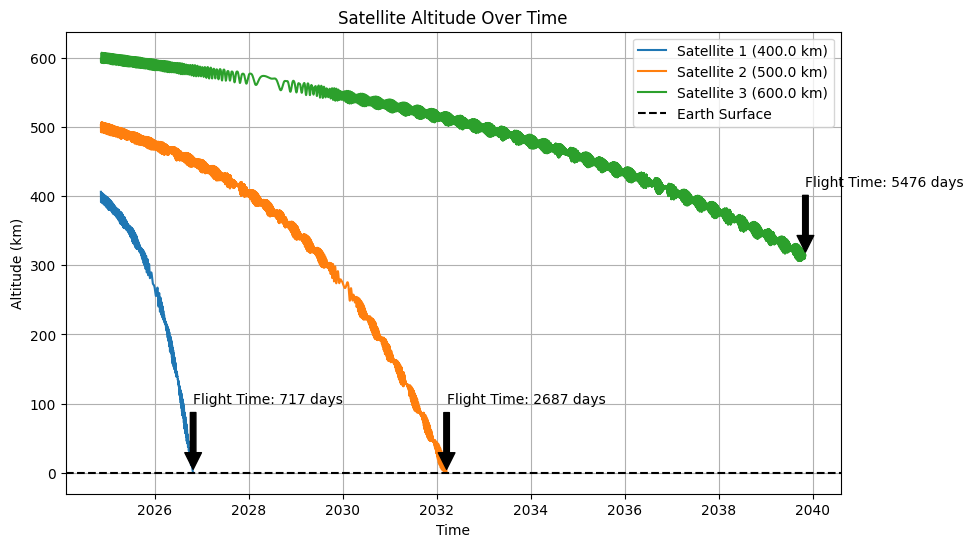

In [43]:
tle_lines = [
    # ISS (LEO)
    (('1 25544U 98067A   20334.54791667  .00016717  00000-0  10270-3 0  9000', 
      '2 25544  51.6442  21.4614 0001448  45.3583 314.7000 15.49112345  9000'), 'ISS (LEO)'),

    # GPS BIIR-2 (MEO)
    (('1 24876U 97035A   20334.54791667  .00000023  00000-0  00000-0 0  9993',
      '2 24876  54.8990  56.0000 0000001  56.0000  56.0000  2.00562500  9993'), 'GPS BIIR-2 (MEO)'),

    # Molniya 1-93 (HEO)
    (('1 24779U 97017A   20334.54791667  .00000023  00000-0  00000-0 0  9993',
      '2 24779  62.8000  56.0000 0000001  56.0000  56.0000  2.00562500  9993'), 'Molniya 1-93 (HEO)'),

    # SES-1 (Geostationary)
    (('1 36516U 10018A   20334.54791667  .00000023  00000-0  00000-0 0  9993',
      '2 36516   0.0180  92.0000 0000001  92.0000 268.0000  1.00270000  9993'), 'SES-1 (GEO)')
]

# Altitudes for which we want to calculate orbital parameters
altitudes = [400, 500, 600]
orbital_params = calc_sun_sync_params(altitudes)
orbit_tle = generate_tle(orbital_params)

## Display the orbital parameters
#print(orbital_params)
#print(orbit_tle)
#print(orbital_params['Period (minutes)'][0])

## Plot the orbits of the satellites
#plot_orbits(orbit_tle, time_delta=4*orbital_params['Period (minutes)'][2]) 
#plot_map(orbit_tle, time_delta=4*orbital_params['Period (minutes)'][2])
plot_orbit_heights(orbit_tle)